# 校园共享单车检测

基于 COCO 预训练 Faster R-CNN 的端到端示例：推理、预处理 `photo` 中的照片、生成伪标签，并在本地照片上进行小规模微调训练。

## 1. 环境检查
- 需要 Python 3.8+，并安装 `torch`、`torchvision`、`Pillow`、`matplotlib`。
- 如缺少依赖（需联网）：`pip install torch torchvision pillow matplotlib`。
- 可选 GPU，CPU 也能运行但速度较慢。

In [1]:
import torch

import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import json
import random
# 允许加载截断图片，避免 PIL 因图片不完整报错
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")


device: cuda


## 2. 加载 COCO 预训练 Faster R-CNN
使用 torchvision 官方 COCO 权重，初始类别列表含背景（索引 0），其中 `bicycle` 为共享单车类别。

In [2]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights, box_score_thresh=0.0)
model.eval().to(device)

current_classes = list(weights.meta["categories"])
id_to_name = {i: name for i, name in enumerate(current_classes)}
bike_label_id = current_classes.index("bicycle")

print(f"加载完成，共 {len(current_classes)} 个类别。自行车类别 id: {bike_label_id}")


加载完成，共 91 个类别。自行车类别 id: 2


## 3. 推理辅助函数
- `run_inference`：单张图像推理，可按分数阈值与共享单车类别过滤。
- `draw_detections`：绘制并可保存检测结果。
- `detect_image`：封装推理与绘制的快捷接口。

In [3]:
def run_inference(img_path, score_thresh=0.4, bike_only=True):
    """在单张图片上执行检测。"""
    img = Image.open(img_path).convert("RGB")
    tensor = F.to_tensor(img).to(device)
    with torch.no_grad():
        outputs = model([tensor])[0]

    boxes = outputs["boxes"].cpu()
    labels = outputs["labels"].cpu()
    scores = outputs["scores"].cpu()

    keep = scores >= score_thresh
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

    if bike_only:
        mask = labels == bike_label_id
        boxes, labels, scores = boxes[mask], labels[mask], scores[mask]

    names = [id_to_name.get(int(i), str(int(i))) for i in labels]
    return boxes, labels, scores, names


def draw_detections(img_path, boxes, labels, scores, names, save_path=None):
    img = Image.open(img_path).convert("RGB")
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img)

    for box, name, score in zip(boxes, names, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="lime", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x1, y1 - 2, f"{name} {score:.2f}",
                fontsize=10, color="yellow",
                bbox=dict(facecolor="black", alpha=0.6, pad=2))

    ax.axis("off")
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()
    plt.close(fig)


def detect_image(img_path, score_thresh=0.4, bike_only=True, save_vis=True):
    boxes, labels, scores, names = run_inference(img_path, score_thresh, bike_only)
    print(f"检测到 {len(boxes)} 个框（分数阈值 >= {score_thresh}）")
    save_path = None
    if save_vis:
        save_path = Path("runs") / f"{Path(img_path).stem}_vis.png"
    draw_detections(img_path, boxes, labels, scores, names, save_path=save_path)
    return boxes, labels, scores, names, save_path


## 4. 单张图片演示
优先选取 `photo/` 中第一张图片；若没有则填入自定义路径。

示例图片路径: photo\微信图片_20251216152615_148_6.jpg
检测到 8 个框（分数阈值 >= 0.4）


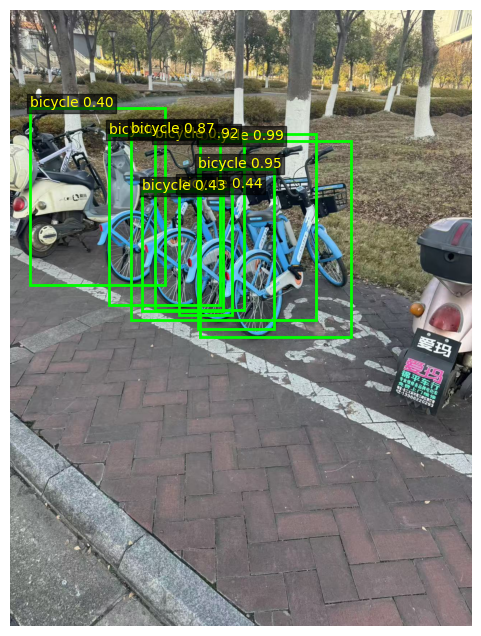

可视化已保存到: runs\微信图片_20251216152615_148_6_vis.png


In [4]:
photo_dir = Path("photo")
candidates = []
if photo_dir.exists():
    candidates = [p for p in sorted(photo_dir.iterdir()) if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}]

sample_path = str(candidates[0]) if candidates else "photo/your_image.jpg"
print("示例图片路径:", sample_path)

if Path(sample_path).exists():
    boxes, labels, scores, names, save_path = detect_image(sample_path, score_thresh=0.4, bike_only=True, save_vis=True)
    print("可视化已保存到:", save_path)
else:
    print(f"未找到示例图片 {sample_path}，请放置一张共享单车照片后重试。")


## 5. 文件夹批量检测
对整个文件夹运行推理并保存可视化与 JSON。默认读取 `photo/`。

In [5]:
def detect_folder(folder="photo", score_thresh=0.4, bike_only=True):
    folder = Path(folder)
    assert folder.exists(), f"未找到目录: {folder}"

    results = []
    for img_path in sorted(folder.iterdir()):
        if img_path.suffix.lower() not in {".jpg", ".jpeg", ".png", ".bmp"}:
            continue
        boxes, labels, scores, names, save_path = detect_image(str(img_path), score_thresh, bike_only, save_vis=True)
        record = {
            "image": str(img_path),
            "boxes": boxes.tolist(),
            "labels": labels.tolist(),
            "scores": scores.tolist(),
            "names": names,
            "viz_path": str(save_path) if save_path else None,
        }
        results.append(record)

    out_path = Path("runs") / "detections.json"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"批量结果已保存到 {out_path}")
    return results


# 示例（目录存在且有图片时再取消注释）
# detect_folder(folder="photo", score_thresh=0.4, bike_only=True)


## 7. 预训练模型生成伪标签（自动标注单车框）
利用 COCO 预训练模型对预处理后的图片自动标注单车框，生成 `dataset/pseudo_labels.json`，作为小样本微调的训练标签。

In [6]:
def pseudo_label_dataset(folder="dataset", score_thresh=0.4):

    data_root = Path(folder) / "images"
    assert data_root.exists(), f"未找到目录: {data_root}，请先运行预处理。"
    img_paths = [p for p in sorted(data_root.glob("*/*")) if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}]
    if not img_paths:
        raise ValueError("未在 dataset/images 下找到图片，请检查预处理输出。")

    results = []
    for img_path in img_paths:
        try:
            boxes, labels, scores, names = run_inference(str(img_path), score_thresh=score_thresh, bike_only=True)
        except OSError as e:
            print(f"跳过损坏/截断图片 {img_path.name}: {e}")
            continue
        record = {
            "image": str(img_path),
            "split": img_path.parent.name,
            "boxes": boxes.tolist(),
            "labels": [1] * len(boxes),  # 新头部只保留 1 个前景类别：单车
            "scores": scores.tolist(),
            "names": names,
        }
        results.append(record)
        print(f"{img_path.name}: {len(boxes)} 个框，分数阈值 {score_thresh}")

    out_path = Path(folder) / "pseudo_labels.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"伪标签已保存到 {out_path}")
    return results


pseudo_labels = pseudo_label_dataset(score_thresh=0.4)


bike_train_001.jpg: 1 个框，分数阈值 0.4
bike_train_002.jpg: 1 个框，分数阈值 0.4
bike_train_003.jpg: 4 个框，分数阈值 0.4
bike_train_004.jpg: 1 个框，分数阈值 0.4
bike_train_005.jpg: 1 个框，分数阈值 0.4
bike_train_006.jpg: 8 个框，分数阈值 0.4
bike_train_007.jpg: 4 个框，分数阈值 0.4
bike_train_008.jpg: 12 个框，分数阈值 0.4
bike_train_009.jpg: 4 个框，分数阈值 0.4
跳过损坏/截断图片 bike_train_010.jpg: cannot identify image file 'dataset\\images\\train\\bike_train_010.jpg'
跳过损坏/截断图片 bike_val_001.jpg: cannot identify image file 'dataset\\images\\val\\bike_val_001.jpg'
跳过损坏/截断图片 bike_val_002.jpg: cannot identify image file 'dataset\\images\\val\\bike_val_002.jpg'
跳过损坏/截断图片 bike_val_003.jpg: cannot identify image file 'dataset\\images\\val\\bike_val_003.jpg'
伪标签已保存到 dataset\pseudo_labels.json


## 8. 数据集与 DataLoader
将伪标签转换为 `torchvision` 检测数据集格式（背景 + 单车 2 类），训练时加入随机水平翻转增强。

In [7]:
class BikeDataset(torch.utils.data.Dataset):
    def __init__(self, pseudo_labels, split="train", hflip_prob=0.5):
        self.items = [x for x in pseudo_labels if x["split"] == split]
        self.split = split
        self.hflip_prob = hflip_prob

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        img = Image.open(item["image"]).convert("RGB")

        boxes = torch.tensor(item["boxes"], dtype=torch.float32)
        labels = torch.tensor(item["labels"], dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        # 随机水平翻转（仅训练集）
        if self.split == "train" and self.hflip_prob > 0 and random.random() < self.hflip_prob:
            img = F.hflip(img)
            if len(boxes) > 0:
                w = img.width
                boxes = boxes.clone()
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
                target["boxes"] = boxes

        img = F.to_tensor(img)
        return img, target


def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), list(targets)


train_dataset = BikeDataset(pseudo_labels, split="train", hflip_prob=0.5)
val_dataset = BikeDataset(pseudo_labels, split="val", hflip_prob=0.0)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

print(f"训练集 {len(train_dataset)} 张，验证集 {len(val_dataset)} 张")


训练集 9 张，验证集 0 张


## 9. 微调训练示例
- 构建只含背景 + 单车两类的检测头，冻结策略不做特别设置（小数据集可配合低学习率）。
- 伪标签质量有限，训练仅作示范，可根据需要手工校正标签后再训练。

In [8]:
def build_finetune_model(num_classes=2):
    m = fasterrcnn_resnet50_fpn(weights=weights, box_score_thresh=0.0)
    in_feat = m.roi_heads.box_predictor.cls_score.in_features
    m.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)
    return m


num_epochs = 5
lr = 1e-4
model_ft = build_finetune_model(num_classes=2).to(device)
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=lr, weight_decay=1e-4)

if len(train_loader) == 0:
    print("训练集为空，检查 photo 是否已预处理并生成伪标签。")
else:
    for epoch in range(num_epochs):
        model_ft.train()
        total_loss = 0.0
        for imgs, targets in train_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: (v.to(device) if torch.is_tensor(v) else v) for k, v in t.items()} for t in targets]

            loss_dict = model_ft(imgs, targets)
            loss = sum(loss_dict.values())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train = total_loss / max(1, len(train_loader))

        # 验证阶段：eval 只返回预测，不会返回 loss
        # 因此切回 train 以取 loss，但关闭梯度计算避免反传
        model_ft.train()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = [img.to(device) for img in imgs]
                targets = [{k: (v.to(device) if torch.is_tensor(v) else v) for k, v in t.items()} for t in targets]
                loss_dict = model_ft(imgs, targets)
                val_loss += sum(loss_dict.values()).item()
        model_ft.eval()
        avg_val = val_loss / max(1, len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs} train {avg_train:.4f} val {avg_val:.4f}")

    # 微调后替换推理模型与类别映射
    model = model_ft.eval()
    current_classes = ["__background__", "bicycle"]
    id_to_name = {i: name for i, name in enumerate(current_classes)}
    bike_label_id = 1


Epoch 1/5 train 0.6633 val 0.0000
Epoch 2/5 train 0.6783 val 0.0000
Epoch 3/5 train 0.4304 val 0.0000
Epoch 4/5 train 0.4066 val 0.0000
Epoch 5/5 train 0.3575 val 0.0000


## 10. 保存微调模型
保存权重到 `runs/finetuned_bike.pth`，后续可重新加载并用于推理。

In [9]:

# ?????????????????? GPU ????
if "model" in globals():
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

save_path = Path("runs") / "finetuned_bike.pth"
save_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model_ft.state_dict(), save_path)
print(f"已保存微调权重: {save_path}")
print("如需直接用微调模型推理，已在上方将 model 切换为微调后的模型，可直接调用 detect_image/detect_folder。")


已保存微调权重: runs\finetuned_bike.pth
如需直接用微调模型推理，已在上方将 model 切换为微调后的模型，可直接调用 detect_image/detect_folder。


## 说明
- 训练集：COCO 预训练 + 本地 `photo` 照片伪标签微调。
- 伪标签可能有误检/漏检，可在生成的 `dataset/pseudo_labels.json` 中手动修正后再训练。
- 若要重新开始：清空/删除 `dataset/` 与 `runs/`，重新运行预处理与伪标签步骤。
- 若训练后推理结果偏少，可降低 `score_thresh`；若误检多，可适度升高。